In [1]:
import numpy as np
import dedalus.public as d3
from dedalus.tools.parallel import Sync
import h5py

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

import time
import logging
logger = logging.getLogger(__name__)

In [2]:
# Numerics Parameters
Nth, Nr = 128, 64
dtype = np.float64

R = 3*2*np.pi

dealias = 3/2
stop_sim_time = 40
timestepper = d3.RK443
dtype = np.float64

#Physics
Rosswave_k = 0.5

In [3]:
# Bases
coords = d3.PolarCoordinates('th', 'r')
dist = d3.Distributor(coords, dtype=dtype)
disk = d3.DiskBasis(coords, shape=(Nth, Nr), radius=R, dealias=dealias, dtype=dtype)
edge = disk.edge
(th,r)= dist.local_grids(disk) 

# Fields
q = dist.Field(bases=disk)
q_IC = dist.Field(bases=disk)
psi = dist.Field(bases=disk)
tau_psi = dist.Field(bases=edge)
tau_z = dist.Field(bases=edge)

beta = dist.Field(bases=disk)
beta['g'] = r*np.sin(th)

# wstr = dist.Field(bases=disk)
# wstr['g'] = -np.sin(4*np.pi*r*np.sin(th))

# Substitutions
lift = lambda A: d3.Lift(A, disk, -1)
grad = lambda A: d3.Gradient(A)
integ = lambda A: d3.Integrate(A, ('r', 'th'))

KE = d3.integ(grad(psi)@grad(psi))/2
# Enstrophy = d3.integ((q)**2)/2

In [4]:
# Problem
problem = d3.IVP([q, psi, tau_psi], namespace=locals())
problem.add_equation("lap(psi) - psi + lift(tau_psi) = q")
problem.add_equation("dt(q) = - skew(grad(psi))@grad(beta)")
problem.add_equation("psi(r=R) = 0")

# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time

2024-04-18 09:47:54,461 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 6s, Rate: 1.1e+01/s
2024-04-18 09:47:54,595 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 2s, Rate: 3.1e+01/s
2024-04-18 09:47:54,740 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 3.8e+01/s
2024-04-18 09:47:54,880 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 1s, Remaining: 1s, Rate: 4.1e+01/s
2024-04-18 09:47:55,035 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 1s, Remaining: 1s, Rate: 4.2e+01/s
2024-04-18 09:47:55,231 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 1s, Rate: 4.1e+01/s
2024-04-18 09:47:55,409 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 1s, Rate: 4.0e+01/s
2024-04-18 09:47:55,557 subsystems 0/1 INFO :: Building subproblem matri

In [5]:
# zeta['g'] = np.exp(-(r*15)**2)*np.sin(r*np.cos(th))*1e-0 
q['g'] = np.exp(-(r/5)**2)*np.sin(r*np.cos(th)*Rosswave_k)

q_IC['g'] = q['g']
r_mat, theta_mat = np.meshgrid(th, r)

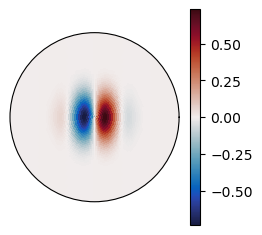

In [6]:
fig = plt.figure(figsize=(15/2.5, 7/2.5))

ax = fig.add_subplot(121, polar=True); ax.grid(False); plt.xticks([]); plt.yticks([]) 
pc = ax.pcolormesh(th.T,r.T,q['g'].T, cmap=cmo.balance, norm=colors.CenteredNorm())
# pc = ax.contour(r_mat,theta_mat,zeta_IC['g'].T,[-0.6,-0.2,0.2,0.6], colors='black')
fig.colorbar(pc)

In [7]:
# Analysis
snapdata = solver.evaluator.add_file_handler('Gyre_waves_snap', sim_dt=10, max_writes=35)
snapdata.add_task(-(-q), name='q')
snapdata.add_task(-(-psi), name='PSI')
snapdata.add_task(-(-beta), name='BETA')

diagdata = solver.evaluator.add_file_handler('Gyre_waves_diag', sim_dt=1, max_writes=200)

# Flow properties
dt_change_freq = 10
flow = d3.GlobalFlowProperty(solver, cadence=dt_change_freq)
flow.add_property(grad(psi)@grad(psi), name='absuv')
flow.add_property(grad(psi)@grad(psi)/2, name='KE')

2024-04-18 09:47:56,210 __main__ 0/1 INFO :: Starting main loop
2024-04-18 09:47:59,985 __main__ 0/1 INFO :: Iteration=11, Time=0.000, dt=1.571e-01, KE=1.587e+00


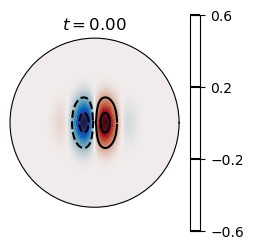

2024-04-18 09:48:01,234 __main__ 0/1 INFO :: Iteration=21, Time=1.571, dt=1.571e-01, KE=1.598e+00


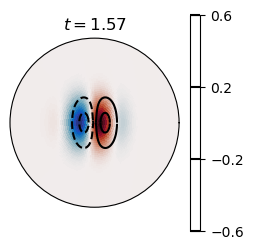

2024-04-18 09:48:02,122 __main__ 0/1 INFO :: Iteration=31, Time=3.142, dt=1.571e-01, KE=1.594e+00


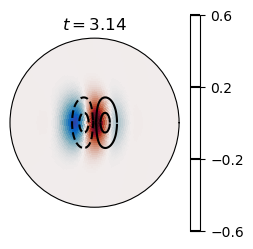

2024-04-18 09:48:02,976 __main__ 0/1 INFO :: Iteration=41, Time=4.712, dt=1.571e-01, KE=1.590e+00


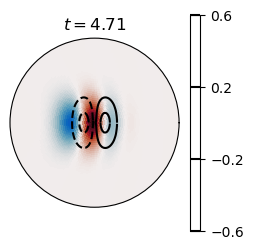

2024-04-18 09:48:03,798 __main__ 0/1 INFO :: Iteration=51, Time=6.283, dt=1.571e-01, KE=1.586e+00


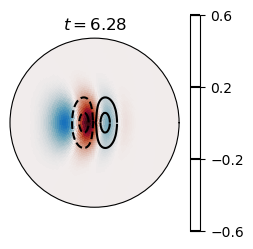

2024-04-18 09:48:04,595 __main__ 0/1 INFO :: Iteration=61, Time=7.854, dt=1.571e-01, KE=1.583e+00


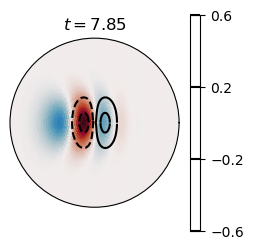

2024-04-18 09:48:05,394 __main__ 0/1 INFO :: Iteration=71, Time=9.425, dt=1.571e-01, KE=1.580e+00


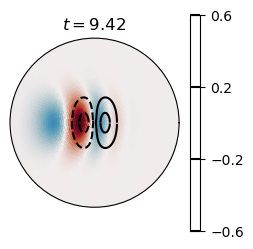

2024-04-18 09:48:06,183 __main__ 0/1 INFO :: Iteration=81, Time=10.996, dt=1.571e-01, KE=1.582e+00


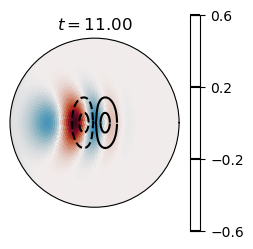

2024-04-18 09:48:07,045 __main__ 0/1 INFO :: Iteration=91, Time=12.566, dt=1.571e-01, KE=1.597e+00


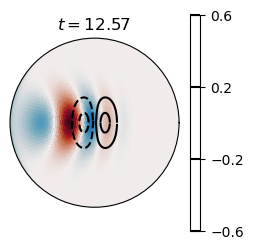

2024-04-18 09:48:07,877 __main__ 0/1 INFO :: Iteration=101, Time=14.137, dt=1.571e-01, KE=1.638e+00


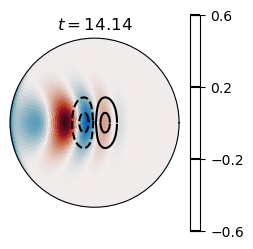

2024-04-18 09:48:08,683 __main__ 0/1 INFO :: Iteration=111, Time=15.708, dt=1.571e-01, KE=1.720e+00


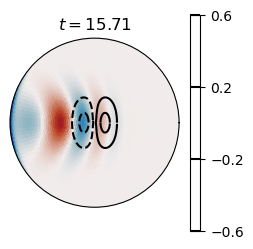

2024-04-18 09:48:09,488 __main__ 0/1 INFO :: Iteration=121, Time=17.279, dt=1.571e-01, KE=1.842e+00


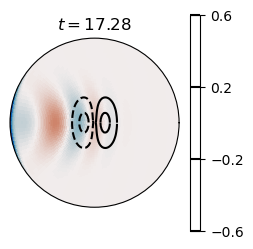

2024-04-18 09:48:10,198 __main__ 0/1 INFO :: Iteration=131, Time=18.850, dt=1.571e-01, KE=1.978e+00


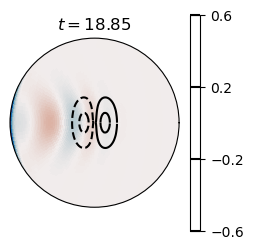

2024-04-18 09:48:10,974 __main__ 0/1 INFO :: Iteration=141, Time=20.420, dt=1.571e-01, KE=2.082e+00


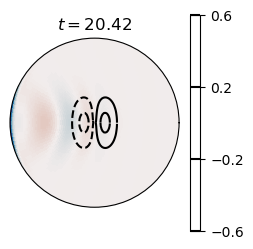

2024-04-18 09:48:11,727 __main__ 0/1 INFO :: Iteration=151, Time=21.991, dt=1.571e-01, KE=2.133e+00


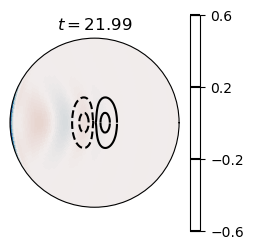

2024-04-18 09:48:12,518 __main__ 0/1 INFO :: Iteration=161, Time=23.562, dt=1.571e-01, KE=2.172e+00


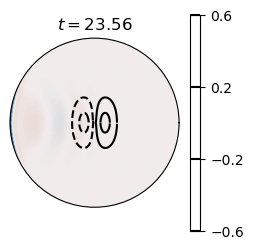

2024-04-18 09:48:13,304 __main__ 0/1 INFO :: Iteration=171, Time=25.133, dt=1.571e-01, KE=2.292e+00


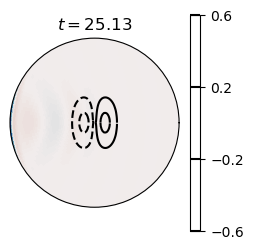

2024-04-18 09:48:14,029 __main__ 0/1 INFO :: Iteration=181, Time=26.704, dt=1.571e-01, KE=2.571e+00


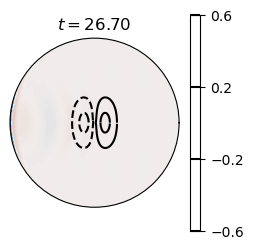

2024-04-18 09:48:14,805 __main__ 0/1 INFO :: Iteration=191, Time=28.274, dt=1.571e-01, KE=2.982e+00


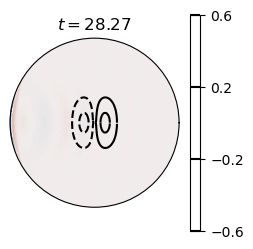

2024-04-18 09:48:15,555 __main__ 0/1 INFO :: Iteration=201, Time=29.845, dt=1.571e-01, KE=3.394e+00


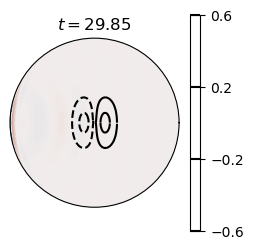

2024-04-18 09:48:16,354 __main__ 0/1 INFO :: Iteration=211, Time=31.416, dt=1.571e-01, KE=3.672e+00


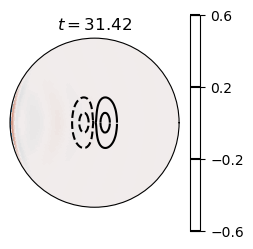

2024-04-18 09:48:17,051 __main__ 0/1 INFO :: Iteration=221, Time=32.987, dt=1.571e-01, KE=3.796e+00


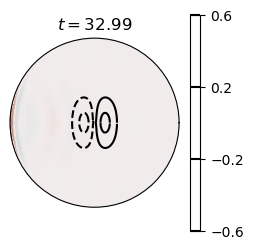

2024-04-18 09:48:17,797 __main__ 0/1 INFO :: Iteration=231, Time=34.558, dt=1.571e-01, KE=3.870e+00


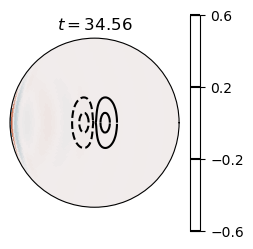

2024-04-18 09:48:18,565 __main__ 0/1 INFO :: Iteration=241, Time=36.128, dt=1.571e-01, KE=4.004e+00


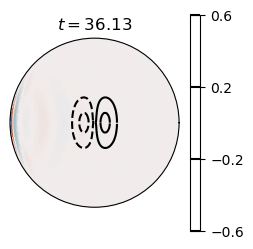

2024-04-18 09:48:19,274 __main__ 0/1 INFO :: Iteration=251, Time=37.699, dt=1.571e-01, KE=4.202e+00


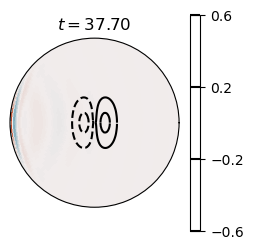

2024-04-18 09:48:20,072 __main__ 0/1 INFO :: Iteration=261, Time=39.270, dt=1.571e-01, KE=4.380e+00


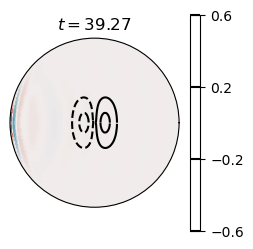

2024-04-18 09:48:20,504 solvers 0/1 INFO :: Simulation stop time reached.
2024-04-18 09:48:20,504 solvers 0/1 INFO :: Final iteration: 266
2024-04-18 09:48:20,505 solvers 0/1 INFO :: Final sim time: 40.055307433270045
2024-04-18 09:48:20,506 solvers 0/1 INFO :: Setup time (init - iter 0): 3.294 sec
2024-04-18 09:48:20,507 solvers 0/1 INFO :: Warmup time (iter 0-10): 2.222 sec
2024-04-18 09:48:20,508 solvers 0/1 INFO :: Run time (iter 10-end): 20.62 sec
2024-04-18 09:48:20,509 solvers 0/1 INFO :: CPU time (iter 10-end): 0.005728 cpu-hr
2024-04-18 09:48:20,510 solvers 0/1 INFO :: Speed: 6.165e+05 mode-stages/cpu-sec


In [8]:
# Main loop
# Main loop
timestep = 1e-7
delr = R/Nr
try:
    logger.info('Starting main loop')
    solver.step(timestep)
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % dt_change_freq == 0:
            maxU = max(1e-10,np.sqrt(flow.max('absuv')))
            # timestep_CFL = delr/maxU*0.7
            # timestep = min(max(1e-5, timestep_CFL), 100)
            timestep = np.pi/20
        if (solver.iteration-1) % 10 == 0:
            KE_prop = flow.volume_integral('KE')
            logger.info('Iteration=%i, Time=%.3f, dt=%.3e, KE=%.3e' %(solver.iteration, solver.sim_time, timestep, KE_prop))

            fig = plt.figure(figsize=(15/2.5, 7/2.5))

            q.change_scales(1), q_IC.change_scales(1)
            ax = fig.add_subplot(121, polar=True); ax.grid(False); plt.xticks([]); plt.yticks([]) 
            pc = ax.pcolormesh(th.T,r.T,q['g'].T, cmap=cmo.balance, norm=colors.CenteredNorm())
            pc = ax.contour(r_mat,theta_mat,q_IC['g'].T,[-0.6,-0.2,0.2,0.6], colors='black')
            fig.colorbar(pc); 
            plt.title("$t=%.2f$" %solver.sim_time)

            plt.show()

except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()